In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 32
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [3]:
x.size()

torch.Size([1, 4, 32])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

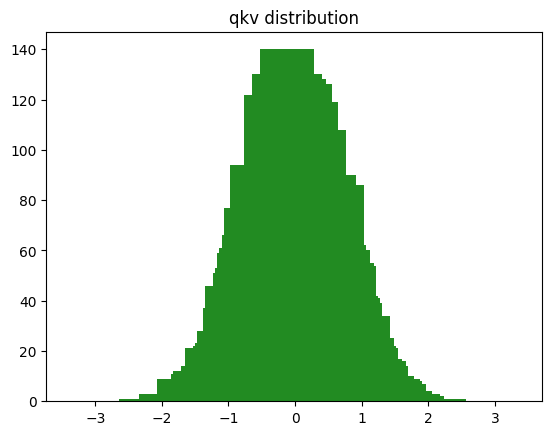

In [7]:
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')
plt.show()

In [8]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [9]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [10]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for Multi-head

In [12]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [13]:
k.T.shape  # We should not use this, because it is four-dimension

C:\Users\86183\AppData\Local\Temp\ipykernel_11060\3997191513.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  k.T.shape  # We should not use this, because it is four-dimension


torch.Size([64, 4, 8, 1])

In [14]:
y = torch.randn((2, 3))
torch.transpose(y, 0, 1) # Turn shape(2, 3) to shape(3, 2)

tensor([[ 0.1846, -0.3508],
        [-0.3807,  0.0208],
        [ 1.8656, -0.6893]])

In [15]:
torch.transpose(y, 1, 0)

tensor([[ 0.1846, -0.3508],
        [-0.3807,  0.0208],
        [ 1.8656, -0.6893]])

In [16]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [17]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [18]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [19]:
(scaled + mask)[0][0]

tensor([[ 0.0490,    -inf,    -inf,    -inf],
        [ 0.4005,  0.2372,    -inf,    -inf],
        [-0.2939,  0.0830,  0.1027,    -inf],
        [ 0.1220,  0.7313,  0.4508,  0.1825]], grad_fn=<SelectBackward0>)

In [20]:
scaled += mask

In [21]:
attetion = F.softmax(scaled, dim=-1)

In [22]:
attetion.shape

torch.Size([1, 8, 4, 4])

In [23]:
attetion[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5408, 0.4592, 0.0000, 0.0000],
        [0.2535, 0.3696, 0.3769, 0.0000],
        [0.1890, 0.3476, 0.2626, 0.2008]], grad_fn=<SelectBackward0>)

In [24]:
values = torch.matmul(attetion, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [25]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [26]:
values, attetion = scaled_dot_product_attention(q, k, v, mask=mask)

In [27]:
attetion.shape

torch.Size([1, 8, 4, 4])

In [28]:
attetion[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5408, 0.4592, 0.0000, 0.0000],
        [0.2535, 0.3696, 0.3769, 0.0000],
        [0.1890, 0.3476, 0.2626, 0.2008]], grad_fn=<SelectBackward0>)

In [29]:
values.size()

torch.Size([1, 8, 4, 64])

In [30]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [31]:
linear_layer = nn.Linear(d_model, d_model)

In [32]:
out = linear_layer(values)

In [33]:
out.shape

torch.Size([1, 4, 512])

In [34]:
out

tensor([[[ 0.0999,  0.5848,  0.0976,  ...,  0.4637,  0.0204, -0.0242],
         [-0.1156, -0.0478, -0.1861,  ...,  0.5174, -0.0800, -0.2994],
         [ 0.3238, -0.2023,  0.2258,  ...,  0.1186,  0.0608,  0.1076],
         [ 0.2694,  0.4962,  0.0677,  ...,  0.0399, -0.1956,  0.0491]]],
       grad_fn=<ViewBackward0>)

## Class

In [35]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class Multi_heads_Attention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f'x.size(): {x.size()}')
        qkv = self.qkv_layer(x)
        print(f'qkv.size(): {qkv.size()}')
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f'qkv.size(): {qkv.size()}')
        qkv = qkv.permute(0, 2, 1, 3)
        print(f'qkv.size(): {qkv.size()}')
        q, k, v = qkv.chunk(3, dim=-1)
        print(f'q.size(): {q.size()}, k.size(): {k.size()}, v.size(): {v.size()}')
        values, attention = scaled_dot_product_attention(q, k, v, mask)
        print(f'values.size(): {values.size()}, attention.size(): {attention.size()}')
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f'values.size(): {values.size()}')
        out = self.linear_layer(values)
        print(f'out.size(): {out.size()}')
        return out

In [36]:
input_dim = 1024
d_model = 512
num_heads = 8
batch_size = 32
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = Multi_heads_Attention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([32, 5, 1024])
qkv.size(): torch.Size([32, 5, 1536])
qkv.size(): torch.Size([32, 5, 8, 192])
qkv.size(): torch.Size([32, 8, 5, 192])
q.size(): torch.Size([32, 8, 5, 64]), k.size(): torch.Size([32, 8, 5, 64]), v.size(): torch.Size([32, 8, 5, 64])
values.size(): torch.Size([32, 8, 5, 64]), attention.size(): torch.Size([32, 8, 5, 5])
values.size(): torch.Size([32, 5, 512])
out.size(): torch.Size([32, 5, 512])
